In [36]:
import numpy as np
import pandas as pd
import os 

import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from collections import Counter
import nltk
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rbern\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rbern\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rbern\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Load, Explore and Process the Data

In [23]:
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'Dados'))

# Define file paths
train_file = os.path.join(data_path, 'train.csv')
test_file = os.path.join(data_path, 'test.csv')

# Load the datasets into DataFrames
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

In [24]:
print(df_train.head(5), df_train.tail(5))
print(df_test.head(5), df_test.tail(5))

                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0                                                    text  label
9538  The Week's Gainers and Losers on the Stoxx Eur...      2
9539  Tupperware Brands among consumer gainers; Unil...      2
9540  vTv Therapeutics leads healthcare gainers; Myo...      2
9541    WORK, XPO, PYX and AMKR among after hour movers      2
9542             YNDX, I, QD and OESX among tech movers      2
   id                                               text
0   0  ETF assets to surge tenfold in 10 years to $50...
1   1  Here’s What Hedge Funds Think Evolution Petrol...
2   2  $PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3   3  China is in the process of 

In [25]:
stop_words = set(stopwords.words('english')) 

# Preprocessing
def clean_and_tokenize_nltk(text):
    # Lowercase
    text = str(text).lower()
    # Remove URLs
    text = re.sub(r"http\S+|www.\S+", "", text)
    # Tokenização com nltk
    tokens = word_tokenize(text)
    # Remove ponctuation and numbers
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Aplicar ao DataFrame
df_train['tokens'] = df_train['text'].apply(clean_and_tokenize_nltk)

In [26]:
df_train['num_words'] = df_train['tokens'].apply(len)
mean_words = df_train['num_words'].mean()
max_words = df_train['num_words'].max()
min_words = df_train['num_words'].min()
print(f"Average number of words per text: {mean_words:.2f}")
print(f"Max number of words per text: {max_words:.2f}")
print(f"Min number of words per text: {min_words:.2f}")

Average number of words per text: 7.65
Max number of words per text: 27.00
Min number of words per text: 0.00


In [27]:
df_train

,text,label,tokens,num_words
0,$BYND - JPMorgan reels in expectations on Beyo...,0,"[bynd, jpmorgan, reels, expectations, beyond, ...",6
1,$CCL $RCL - Nomura points to bookings weakness...,0,"[ccl, rcl, nomura, points, bookings, weakness,...",9
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,"[cx, cemex, cut, credit, suisse, morgan, weak,...",9
3,$ESS: BTIG Research cuts to Neutral https://t....,0,"[ess, btig, research, cuts, neutral]",5
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,"[fnko, funko, slides, piper, jaffray, pt, cut]",7
...,...,...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2,"[week, gainers, losers, stoxx, europe, economy...",7
9539,Tupperware Brands among consumer gainers; Unil...,2,"[tupperware, brands, among, consumer, gainers,...",8
9540,vTv Therapeutics leads healthcare gainers; Myo...,2,"[vtv, therapeutics, leads, healthcare, gainers...",10
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,"[work, xpo, pyx, amkr, among, hour, movers]",7


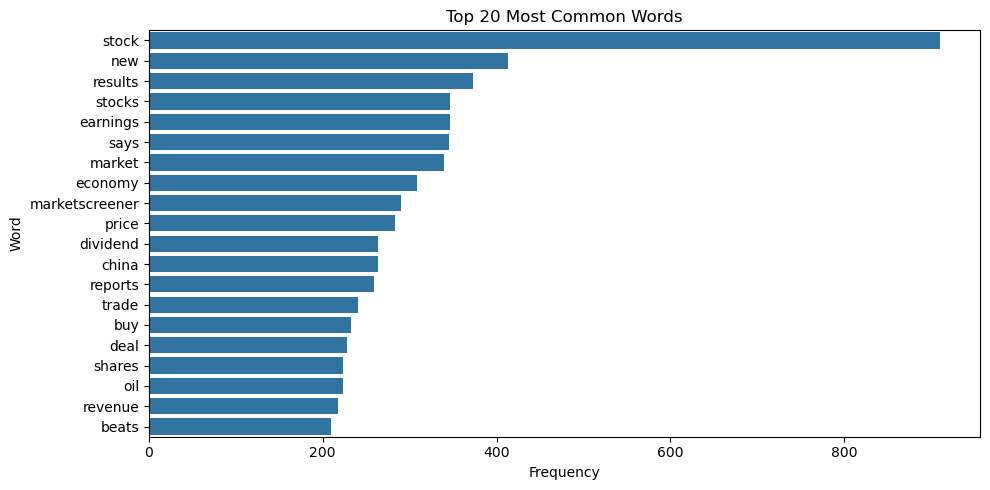

In [28]:
# Flatten the list of all tokens
all_tokens = [token for tokens in df_train['tokens'] for token in tokens]

# Calculate word frequencies
token_freq = Counter(all_tokens)
most_common = token_freq.most_common(20)

# Convert to DataFrame
freq_df = pd.DataFrame(most_common, columns=['word', 'frequency'])

# Plot the 20 most common words
plt.figure(figsize=(10, 5))
sns.barplot(x='frequency', y='word', data=freq_df)
plt.title('Top 20 Most Common Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

C:\Users\rbern\AppData\Local\Temp\ipykernel_11352\1172918029.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x='label', palette='Set2')


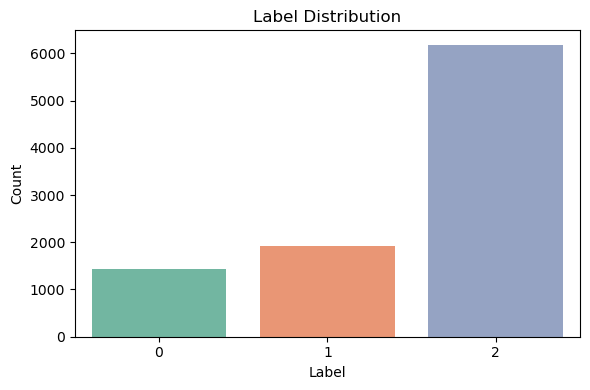

In [29]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_train, x='label', palette='Set2')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

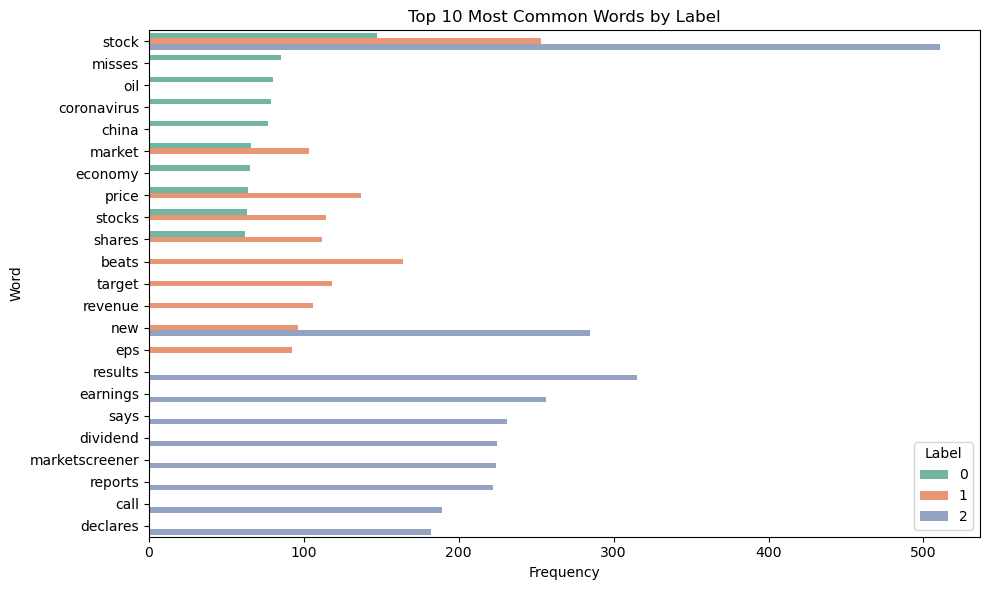

In [30]:
top_words_per_label = {}

# Frequency of tokens per label
for label in df_train['label'].unique():
    tokens = df_train[df_train['label'] == label]['tokens']
    flat_tokens = [token for sublist in tokens for token in sublist]
    freq = Counter(flat_tokens).most_common(10)
    top_words_per_label[label] = freq


top_words_df = pd.DataFrame([
    {'label': label, 'word': word, 'frequency': freq}
    for label, words in top_words_per_label.items()
    for word, freq in words
])


plt.figure(figsize=(10, 6))
sns.barplot(data=top_words_df, x='frequency', y='word', hue='label', palette='Set2')
plt.title('Top 10 Most Common Words by Label')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

In [31]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_ngrams = vectorizer.fit_transform(df_train['text'])
ngrams_freq = zip(vectorizer.get_feature_names_out(), X_ngrams.sum(axis=0).tolist()[0])
sorted_ngrams = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:20]


In [32]:
sorted_ngrams

[('marketscreener https', 478),
 ('stock marketscreener', 315),
 ('hedge funds', 163),
 ('price target', 141),
 ('economy marketscreener', 137),
 ('stock market', 137),
 ('stock price', 109),
 ('q3 results', 99),
 ('earnings conference', 90),
 ('conference presentation', 89),
 ('edited transcript', 89),
 ('stock https', 89),
 ('beats revenue', 85),
 ('seeking alpha', 85),
 ('market update', 84),
 ('eps beats', 82),
 ('alpha https', 80),
 ('reports q3', 79),
 ('target raised', 74),
 ('dividend https', 71)]

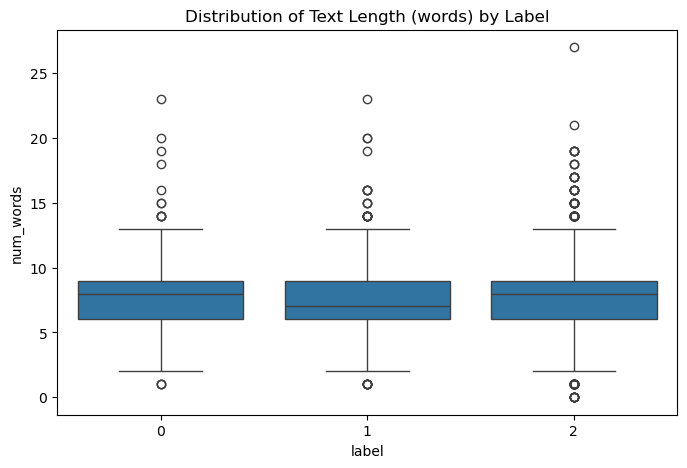

In [33]:

df_train['num_words'] = df_train['tokens'].apply(len)

plt.figure(figsize=(8, 5))
sns.boxplot(x='label', y='num_words', data=df_train)
plt.title("Distribution of Text Length (words) by Label")
plt.show()

In [34]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df_train['text'])
y = df_train['label']

## Split the data and building models 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [ ]:
# Simple model 
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.40      0.53       288
           1       0.83      0.53      0.65       385
           2       0.78      0.96      0.86      1236

    accuracy                           0.79      1909
   macro avg       0.80      0.63      0.68      1909
weighted avg       0.79      0.79      0.77      1909



Só mesmo um modelo simples e resultados engraçados até, tentar ver com outos modelos e resolver o imbalance